# Homework 01: Multivariate Parametric Classification
## Kerem Girenes, 0069671
## March 13, 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

def safelog(x):
    return(np.log(x + 1e-100))

## Parameters

In [2]:
np.random.seed(421)
# mean parameters
class_means = np.array([[+0.0, +4.5],
                        [-4.5, -1.0],
                        [+4.5, -1.0],
                        [+0.0, -4.0]])
# covariance parameters
class_covariances = np.array([[[+3.2, +0.0], 
                               [+0.0, +1.2]],
                              
                              [[+1.2, +0.8], 
                               [+0.8, +1.2]],
                              
                              [[+1.2, -0.8], 
                               [-0.8, +1.2]],
                              
                              [[+1.2, +0.0], 
                               [+0.0, +3.2]]])
# sample sizes
class_sizes = np.array([105, 145, 135, 115])

## Data Generation

In [3]:
# generate random samples
points1 = np.random.multivariate_normal(mean = class_means[0,:],
                                        cov = class_covariances[0,:,:],
                                        size = class_sizes[0])
points2 = np.random.multivariate_normal(mean = class_means[1,:],
                                        cov = class_covariances[1,:,:],
                                        size = class_sizes[1])
points3 = np.random.multivariate_normal(mean = class_means[2,:],
                                        cov = class_covariances[2,:,:],
                                        size = class_sizes[2])
points4 = np.random.multivariate_normal(mean = class_means[3,:],
                                        cov = class_covariances[3,:,:],
                                        size = class_sizes[3])
X = np.vstack((points1, points2, points3, points4))

# generate corresponding labels
y = np.concatenate((np.repeat(1, class_sizes[0]),
                    np.repeat(2, class_sizes[1]),
                    np.repeat(3, class_sizes[2]),
                    np.repeat(4, class_sizes[3])))

## Exporting Data

In [4]:
# write data to a file
np.savetxt("hw01_data_set.csv", np.hstack((X, y[:, None])), fmt = "%f,%f,%d")

## Plotting Data

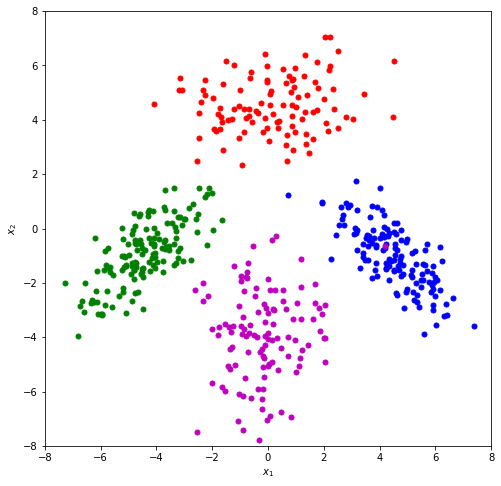

In [5]:
x1_interval = np.linspace(-8, +8, 1001)
x2_interval = np.linspace(-8, +8, 1001)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)
X_grid = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

D1 = stats.multivariate_normal.pdf(X_grid, mean = class_means[0,:],
                                   cov = class_covariances[0,:,:])
D1 = D1.reshape((len(x1_interval), len(x2_interval)))
D2 = stats.multivariate_normal.pdf(X_grid, mean = class_means[1,:],
                                   cov = class_covariances[1,:,:])
D2 = D2.reshape((len(x1_interval), len(x2_interval)))
D3 = stats.multivariate_normal.pdf(X_grid, mean = class_means[2,:],
                                   cov = class_covariances[2,:,:])
D3 = D3.reshape((len(x1_interval), len(x2_interval)))
D4 = stats.multivariate_normal.pdf(X_grid, mean = class_means[3,:],
                                   cov = class_covariances[3,:,:])
D4 = D4.reshape((len(x1_interval), len(x2_interval)))

# plot data points generated
plt.figure(figsize = (8, 8))
plt.plot(points1[:,0], points1[:,1], "r.", markersize = 10)
plt.plot(points2[:,0], points2[:,1], "g.", markersize = 10)
plt.plot(points3[:,0], points3[:,1], "b.", markersize = 10)
plt.plot(points4[:,0], points4[:,1], "m.", markersize = 10)

plt.xlim((-8, +8))
plt.ylim((-8, +8))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Importing Data

In [6]:
# read data into memory
data_set = np.genfromtxt("hw01_data_set.csv", delimiter = ",")

# get x and y_truth values
X = data_set[:,[0, 1]]
y_truth = data_set[:,2].astype(int)

# get number of classes and number of samples
K = np.max(y)
N = data_set.shape[0]

## Estimation of Parameters

In [7]:
# sample means
sample_means = np.array([np.mean(X[y_truth == (c+1)], axis=0) for c in range(K)])

print("Sample Means:\n")
print(sample_means)

    
# sample covariances
sample_covariances = np.array([np.matmul((X[y_truth == (c + 1)] - sample_means[c]).T,
                                 X[y_truth == (c + 1)] - sample_means[c])
                      /class_sizes[c]
                      for c in range(K)])

print("\nSample Covariances:\n")
print(sample_covariances,"\n")
    
    
# class priors
class_priors = np.array([np.mean(y_truth == (c + 1)) for c in range(K)])

print("Class Priors:\n", class_priors)

Sample Means:

[[ 0.14550242  4.55638821]
 [-4.45510875 -0.92632899]
 [ 4.48187484 -1.02664886]
 [-0.15761942 -3.93467956]]

Sample Covariances:

[[[ 2.88774467  0.26160804]
  [ 0.26160804  1.02301075]]

 [[ 1.43606841  1.01209997]
  [ 1.01209997  1.36898642]]

 [[ 1.2777115  -0.95351749]
  [-0.95351749  1.29984191]]

 [[ 1.32615908  0.27672137]
  [ 0.27672137  2.80556549]]] 

Class Priors:
 [0.21 0.29 0.27 0.23]


## Parameter Classification

In [8]:
D = 2
W = np.array([- 0.5 * np.linalg.inv(sample_covariances[c]) for c in range(K)])
w = np.array([np.dot(np.linalg.inv(sample_covariances[c]), sample_means[c]) for c in range(K)])
w0 = np.array([- 0.5 * np.dot(sample_means[c].T, np.dot(np.linalg.inv(sample_covariances[c]), sample_means[c]))
      - (D/2) * safelog(2 * np.pi)
      - 0.5 * safelog(np.linalg.det(sample_covariances[c]))
      + safelog(class_priors[c]) for c in range(K)])

## Score Function

In [9]:
# define the score function
def g(c, x):
    return np.dot(np.dot(X[x].T, W[c]), X[x]) + np.dot(w[c].T, X[x]) + w0[c]

## Predicted Values

In [10]:
y_predicted = []
for x in range(len(X)):
    max_index = np.argmax([g(c, x) for c in range(K)])
    y_predicted = np.append(y_predicted, max_index)

## Confusion Matrix

In [11]:
confusion_matrix = pd.crosstab(y_predicted, y_truth, 
                               rownames = ["y_pred"], 
                               colnames = ["y_truth"])
print(confusion_matrix)

y_truth    1    2    3    4
y_pred                     
0.0      105    0    0    0
1.0        0  145    0    0
2.0        0    0  133    1
3.0        0    0    2  114


## Decision Boundaries

In [12]:
import warnings
warnings.simplefilter('ignore', UserWarning)

x1_interval = np.linspace(-8, +8, 2001)
x2_interval = np.linspace(-8, +8, 2001)
x1_grid, x2_grid = np.meshgrid(x1_interval, x2_interval)

discriminants = np.zeros((2001, 2001, 4))

discriminants[:,:,0] = W[0][0][0] * x1_grid**2 + W[0][0][1] * x1_grid * x2_grid + W[0][1][0] * x1_grid * x2_grid + W[0][1][1] * x2_grid**2 + w[0][0] * x1_grid + w[0][1] * x2_grid + w0[0]
discriminants[:,:,1] = W[1][0][0] * x1_grid**2 + W[1][0][1] * x1_grid * x2_grid + W[1][1][0] * x1_grid * x2_grid + W[1][1][1] * x2_grid**2 + w[1][0] * x1_grid + w[1][1] * x2_grid + w0[1]
discriminants[:,:,2] = W[2][0][0] * x1_grid**2 + W[2][0][1] * x1_grid * x2_grid + W[2][1][0] * x1_grid * x2_grid + W[2][1][1] * x2_grid**2 + w[2][0] * x1_grid + w[2][1] * x2_grid + w0[2]
discriminants[:,:,3] = W[3][0][0] * x1_grid**2 + W[3][0][1] * x1_grid * x2_grid + W[3][1][0] * x1_grid * x2_grid + W[3][1][1] * x2_grid**2 + w[3][0] * x1_grid + w[3][1] * x2_grid + w0[3]
  
for c in range(K):
    for i in range(K):
        for j in range(i+1,K):
            if c != i and c != j:  
                discriminants[:,:,c][(discriminants[:,:,c] < discriminants[:,:,i]) & (discriminants[:,:,c] < discriminants[:,:,j])] = np.nan

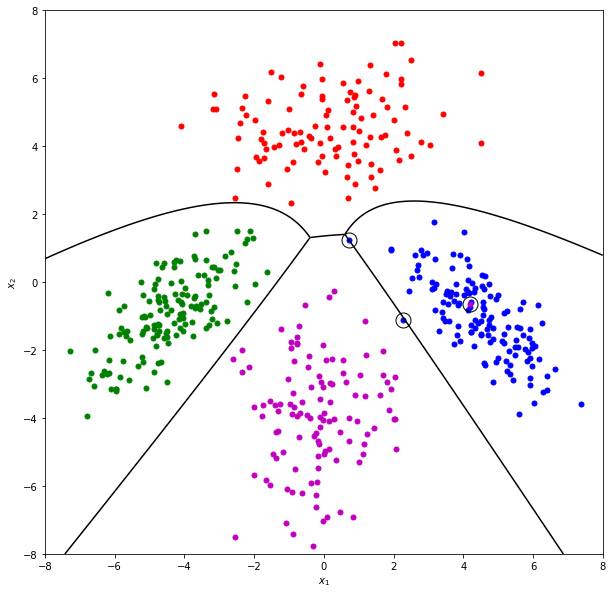

In [20]:
plt.figure(figsize = (10, 10))
plt.plot(X[y == 1, 0], X[y == 1, 1], "r.", markersize = 10)
plt.plot(X[y == 2, 0], X[y == 2, 1], "g.", markersize = 10)
plt.plot(X[y == 3, 0], X[y == 3, 1], "b.", markersize = 10)
plt.plot(X[y == 4, 0], X[y == 4, 1], "m.", markersize = 10)

for x in range(len(X)):
    if(y_predicted[x]+1 != y_truth[x]):
        plt.plot(X[x][0], X[x][1], "ko", markersize = 15, fillstyle = "none")
        
plt.contour(x1_grid, x2_grid, discriminants[:,:,0] - discriminants[:,:,1], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminants[:,:,0] - discriminants[:,:,2], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminants[:,:,0] - discriminants[:,:,3], levels = 0, colors = "k")

plt.contour(x1_grid, x2_grid, discriminants[:,:,1] - discriminants[:,:,2], levels = 0, colors = "k")
plt.contour(x1_grid, x2_grid, discriminants[:,:,1] - discriminants[:,:,3], levels = 0, colors = "k")

plt.contour(x1_grid, x2_grid, discriminants[:,:,2] - discriminants[:,:,3], levels = 0, colors = "k")

point_colors = ['r', 'g', 'b', 'm']

plt.xlim((-8, +8))
plt.ylim((-8, +8))
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()